In [2]:
#Import packages 
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , Input
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
import tensorflow_datasets as tfds
from keras.utils import plot_model

Using TensorFlow backend.


In [4]:
#Define the Hyperparameters
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

In [4]:
#Define dataset paths "Minisun"
MiniSun_train_path = "D:/Pre-Master & CV/Computer vision Master/Few shot learning MiniSun/MiniSun/train"
MiniSun_val_path = "D:/Pre-Master & CV/Computer vision Master/Few shot learning MiniSun/MiniSun/validation"
MiniSun_test_path = "D:/Pre-Master & CV/Computer vision Master/Few shot learning MiniSun/MiniSun/test"

In [73]:
class Dataset:

    def __init__(self, training):

        split = "train" if training else "test"
        def Build_data(Data_Path):
            data = {}
            Counter = 0
            for root, dirs, files in os.walk(Data_Path):
                data.update({Counter: []})
                for file in files:
                    File_path = os.path.join(root, file)
                    # Read examples from files in the filename queue.
                    image = tf.io.read_file(File_path)
                    #Magical line :)
                    image = tf.image.decode_jpeg(image)/255
                    data[Counter - 1].append(image)
                Counter = Counter + 1
            data.popitem()
            return data, list(data.keys())

        if training:
            self.data, self.labels = Build_data(MiniSun_train_path)
        else:
            self.data, self.labels = Build_data(MiniSun_test_path)

    def get_mini_dataset(
            self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots,num_classes))
        temp_images = np.zeros(shape=(num_classes * shots, 84, 84, 3))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 84, 84, 3))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            khara = np.zeros(num_classes)
            khara[class_idx]=1
            temp_labels[class_idx * shots: (class_idx + 1) * shots] = khara
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                class_idx * shots: (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                class_idx * shots: (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
                 return dataset, test_images, test_labels
        return dataset

In [6]:
#Model build 
#Input shape 28,28,1
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(84,84, 3))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
#optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 42, 42, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 42, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 21, 21, 64)        0     

In [5]:
#MobileNetV2
base_model = keras.applications.MobileNetV2(
    weights=None,  # Load weights pre-trained on ImageNet.
    input_tensor=Input(shape=(84, 84, 3)),
    include_top=False)  # Do not include the ImageNet classifier at the top.

#Freeze the base model.
layer_names=[layer.name for layer in base_model.layers]
base_model.trainable = False

last_layer = base_model.get_layer('Conv1_relu').output
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.BatchNormalization()(last_layer)
x = keras.layers.LeakyReLU()(x)
x = Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(base_model.input, outputs)
keras.optimizers.SGD(learning_rate=learning_rate)
model.summary()
plot_model(model, to_file='model.jpeg', show_shapes=True,show_layer_names=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 84, 84, 3)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 42, 42, 32)        864       
_________________________________________________________________
bn_Conv1 (BatchNormalization (None, 42, 42, 32)        128       
_________________________________________________________________
Conv1_relu (ReLU)            (None, 42, 42, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 42, 42, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 56448)             0     

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

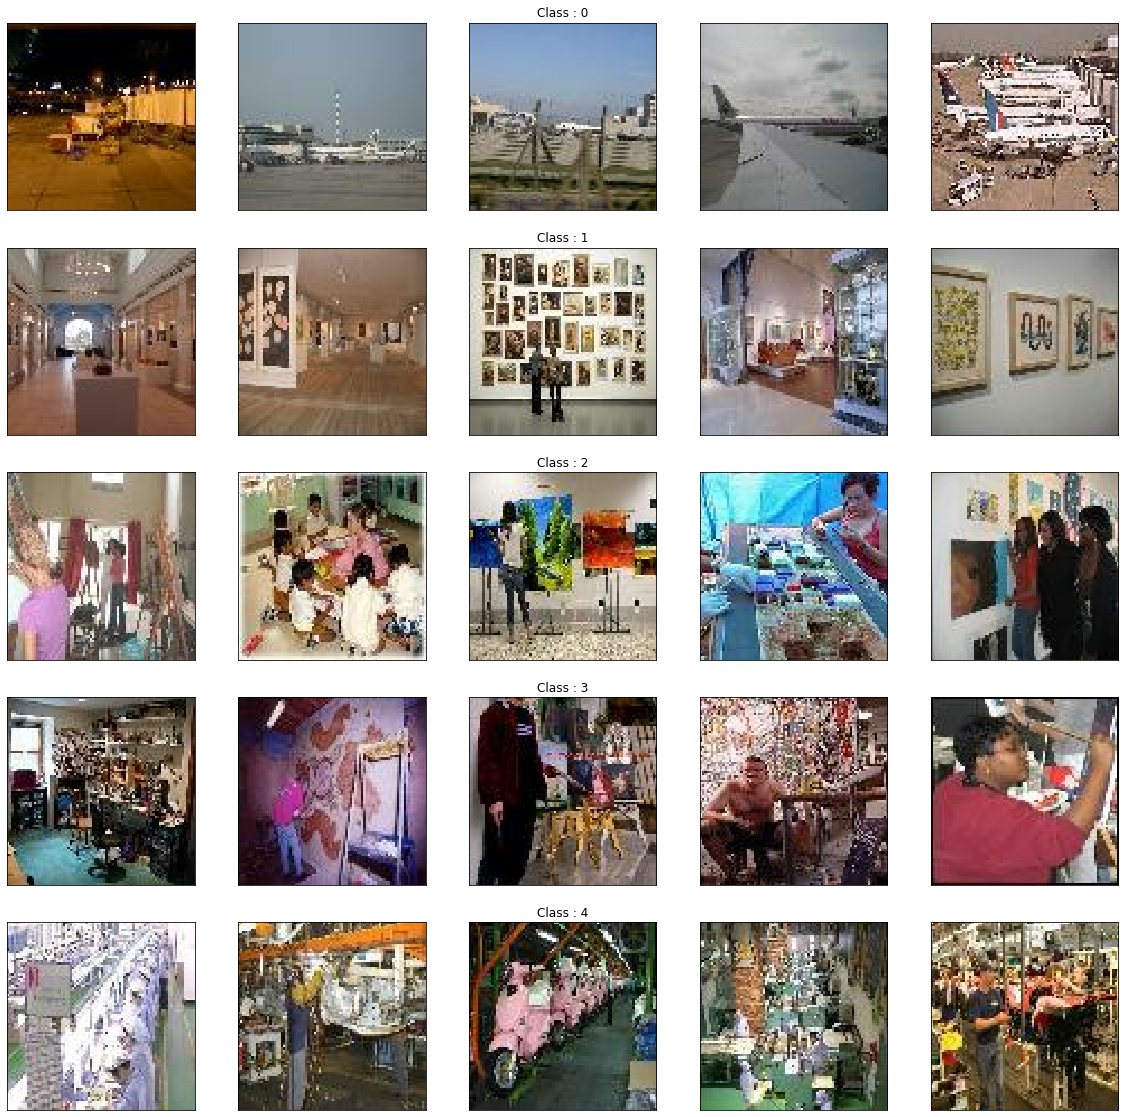

In [70]:
#Load training  and testing data 
Data = Dataset(training=True)
Test = Dataset(training=False)
## Visualize some examples from the dataset

_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(Data.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = Data.data[sample_keys[a]][b]
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + str(sample_keys[a]))
        axarr[a, b].imshow(temp_image)
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

In [72]:
#Train the model 
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = Data.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    intial_vars = model.get_weights()
    i = 0
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        #i=i+1
        #intial_vars = model.get_weights()
        #f = open("intial_vars"+str(i)+".txt", "a")
        #f.writelines(str(intial_vars))
        #f.close()
        new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    meta_vars = model.get_weights()
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (Data, Test):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

batch 0: train=0.400000 test=0.400000
batch 100: train=0.200000 test=0.000000
batch 200: train=0.600000 test=0.600000
batch 300: train=0.400000 test=0.200000
batch 400: train=0.000000 test=0.200000
batch 500: train=0.600000 test=0.200000
batch 600: train=0.600000 test=0.400000
batch 700: train=0.400000 test=0.400000
batch 800: train=0.200000 test=0.200000
batch 900: train=0.000000 test=0.400000
batch 1000: train=0.000000 test=0.400000
batch 1100: train=0.000000 test=0.400000
batch 1200: train=0.800000 test=0.600000
batch 1300: train=0.200000 test=0.200000
batch 1400: train=0.000000 test=0.400000
batch 1500: train=0.200000 test=0.600000
batch 1600: train=0.800000 test=0.800000
batch 1700: train=0.600000 test=0.200000
batch 1800: train=0.200000 test=0.400000
batch 1900: train=0.600000 test=0.400000


In [74]:
#Save model weights 
a = model.get_weights()

np.save('MiniSun_weights.npy',a)

C:\Users\RSH\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [75]:
#Test the model 
Test = Dataset(training=False)
testing = []
for meta_iter in range(1000):
    # Sample a mini dataset from the full dataset.
    train_set, test_images, test_labels = Test.get_mini_dataset(
        eval_batch_size, eval_iters, shots, classes, split=True)
    old_vars = model.get_weights()
    # Train on the samples and get the resulting accuracies.
    for images, labels in train_set:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    test_preds = model.predict(test_images)
    test_preds = tf.argmax(test_preds).numpy()
    num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
    model.set_weights(old_vars)
    accuracies=num_correct / classes
    testing.append(accuracies)
            

In [76]:
acc = np.average(testing)
std = np.std(testing)
ci95= 1.96*std/np.sqrt(1000)
print("ACC= " + str(acc) + "+-"+ str(ci95))

ACC= 0.40120000000000006+-0.01555190033712922


In [ ]:
weights = np.load('Minisun_weights.npy', allow_pickle=True, encoding="latin1").tolist()
model.set_weights(weights)